<a href="https://colab.research.google.com/github/M-Harshitha-2005/Omr_Automation/blob/main/OMR_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

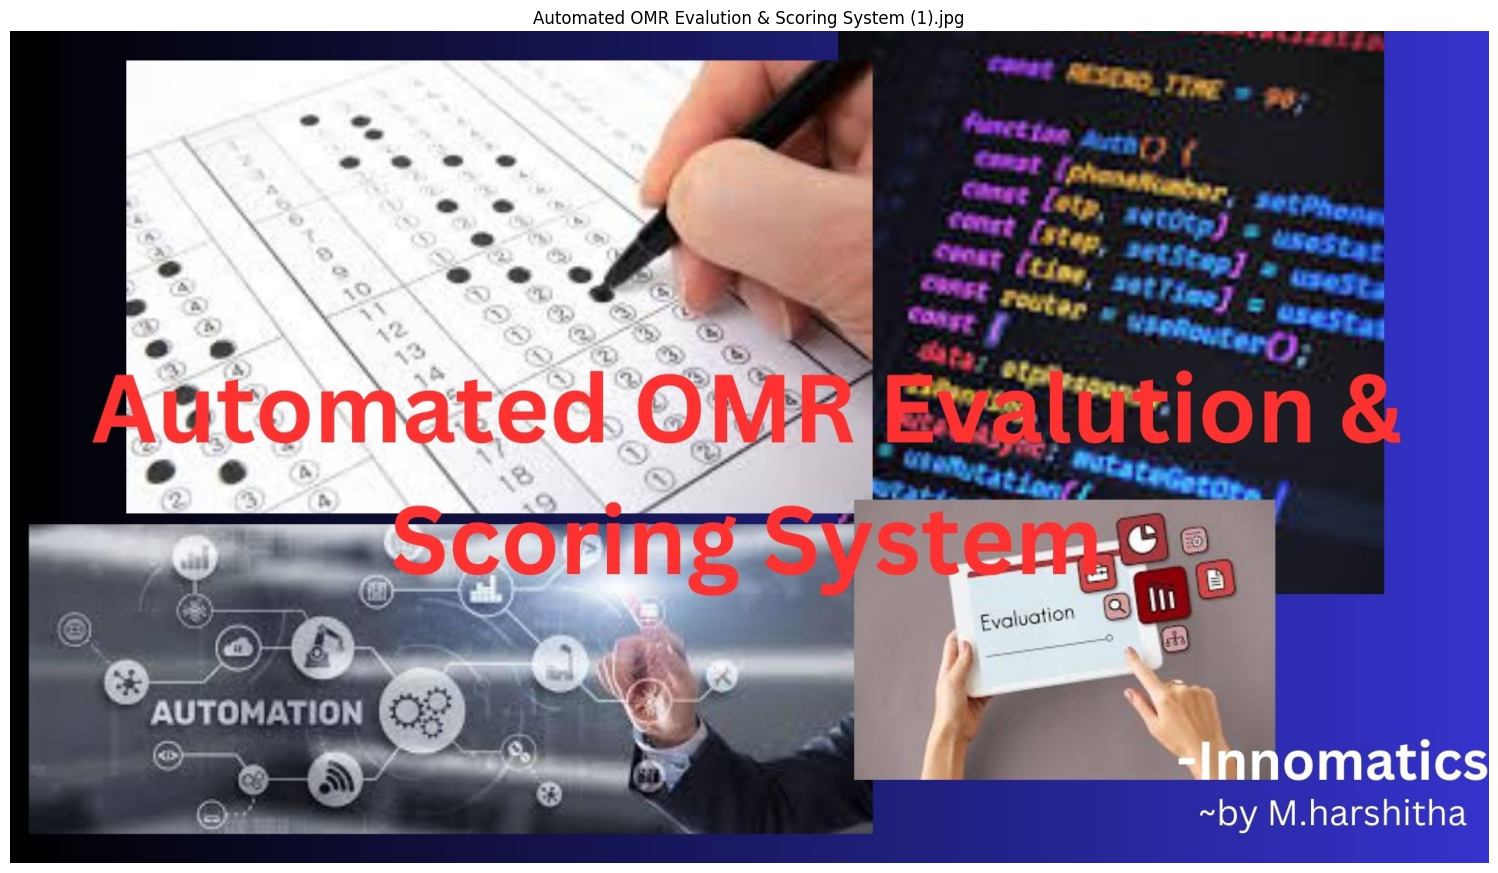

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Replace 'your_image_name.jpg' with the name of your uploaded image file
image_name = 'Automated OMR Evalution & Scoring System (1).jpg' # Updated with the user's filename
image_path = os.path.join('/content/', image_name) # Assuming the image is in the root directory

img = cv2.imread(image_path)

if img is not None:
    # Get image dimensions
    height, width, _ = img.shape

    # Convert BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Adjust figure size to match image dimensions (or a reasonable scale)
    # Using a scale factor to avoid extremely large plots for high-resolution images
    scale_factor = 0.01
    plt.figure(figsize=(width * scale_factor, height * scale_factor))


    plt.imshow(img_rgb)
    plt.title(image_name)
    plt.axis('off') # Hide axes
    plt.show()
else:
    print(f"Error: Could not load image from {image_path}. Please check the file name and path.")

In [ ]:
!pip install --upgrade pip
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import cv2

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [26]:
from google.colab import files
uploaded = files.upload()  # choose your sample_omr_sheets.zip
zip_path = list(uploaded.keys())[0]
print("Uploaded:", zip_path)


Saving sample_omr_sheets.zip to sample_omr_sheets (1).zip
Uploaded: sample_omr_sheets (1).zip


In [15]:
from zipfile import ZipFile
import os

extract_dir = "omr_images"
with ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# List extracted files
os.listdir(extract_dir)


['answer_keys.json',
 'sheet_4.png',
 'sheet_3.png',
 'sheet_1.png',
 'sheet_2.png',
 'sheet_5.png']

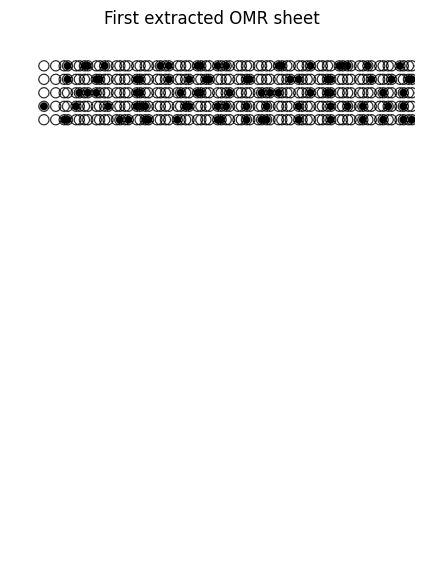

In [16]:
import cv2
from matplotlib import pyplot as plt

def show_image_bgr(img, title=None):
    if img is None:
        print("Error: Could not load image.")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Pick the first extracted image file
image_files = [f for f in os.listdir(extract_dir) if f.endswith('.png')]
if image_files:
    image_file = image_files[0]
    img_path = os.path.join(extract_dir, image_file)
    img_bgr = cv2.imread(img_path)
    show_image_bgr(img_bgr, title="First extracted OMR sheet")
else:
    print("No PNG image files found in the extracted directory.")

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path
import os

plt.rcParams["figure.figsize"] = (10,7)

def show_image_bgr(img, title=None):
    """Display BGR image in Colab using matplotlib."""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    if title: plt.title(title)
    plt.axis('off')
    plt.show()


In [18]:
out_dir = Path("omr_outputs")
out_dir.mkdir(exist_ok=True)


In [19]:
# Warp / document detection
def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]    # top-left
    rect[2] = pts[np.argmax(s)]    # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # top-right
    rect[3] = pts[np.argmax(diff)] # bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts.reshape(4,2))
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def detect_sheet_and_warp(image):
    h,w = image.shape[:2]
    ratio = 800.0 / max(h,w)
    resized = cv2.resize(image, (int(w*ratio), int(h*ratio)))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    docCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        if len(approx) == 4:
            docCnt = approx
            break
    if docCnt is None:
        return image
    scale = max(h,w)/800.0
    docCnt_orig = (docCnt.reshape(4,2)*scale).astype(np.float32)
    warped = four_point_transform(image, docCnt_orig)
    return warped

# Preprocess for bubbles
def preprocess_for_bubbles(warped):
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    denoised = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    return denoised

# Bubble detection
def find_bubble_candidates(thresh_img, min_area=300, max_area=5000):
    cnts, _ = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area or area > max_area: continue
        x,y,w,h = cv2.boundingRect(c)
        ar = w/float(h)
        if ar<0.6 or ar>1.6: continue
        roi = thresh_img[y:y+h, x:x+w]
        filled = cv2.countNonZero(roi)
        filled_ratio = filled / (w*h if w*h>0 else 1)
        cx, cy = x + w//2, y + h//2
        candidates.append({'contour':c,'x':x,'y':y,'w':w,'h':h,'cx':cx,'cy':cy,'filled_ratio':filled_ratio})
    candidates = sorted(candidates, key=lambda d:(d['cy'],d['cx']))
    return candidates

# Grouping and answer extraction
def group_into_rows(candidates, y_tol=15):
    rows=[]
    if not candidates: return rows
    current=[candidates[0]]
    for c in candidates[1:]:
        if abs(c['cy']-current[-1]['cy']) <= y_tol:
            current.append(c)
        else:
            rows.append(sorted(current,key=lambda d:d['cx']))
            current=[c]
    rows.append(sorted(current,key=lambda d:d['cx']))
    return rows

def extract_answers_from_candidates(candidates, options_per_question=4, fill_threshold=0.35):
    rows = group_into_rows(candidates)
    flattened=[]
    for r in rows: flattened.extend(sorted(r,key=lambda d:d['cx']))
    answers=[]
    OPTIONS=['A','B','C','D','E']
    idx=0
    while idx+options_per_question <= len(flattened):
        group = flattened[idx:idx+options_per_question]
        frs = [g['filled_ratio'] for g in group]
        filled_idx = [i for i,fr in enumerate(frs) if fr>=fill_threshold]
        if len(filled_idx)==0:
            answers.append('-')
        elif len(filled_idx)==1:
            answers.append(OPTIONS[filled_idx[0]])
        else:
            answers.append('M')
        idx += options_per_question
    return answers

#  overlay
def draw_overlay(warped, candidates, detected_answers, options_per_question=4):
    overlay = warped.copy()
    flattened=[]
    for r in group_into_rows(candidates):
        flattened.extend(sorted(r,key=lambda d:d['cx']))
    idx=0; q_idx=0
    while idx+options_per_question <= len(flattened) and q_idx<len(detected_answers):
        group = flattened[idx:idx+options_per_question]
        answer = detected_answers[q_idx]
        for i,g in enumerate(group):
            x,y,w,h = g['x'],g['y'],g['w'],g['h']
            cv2.rectangle(overlay,(x,y),(x+w,y+h),(180,180,180),1)
            if g['filled_ratio']>0.02: cv2.circle(overlay,(g['cx'],g['cy']),max(2,min(w,h)//8),(0,255,0),-1)
        if answer in ['A','B','C','D','E']:
            chosen=ord(answer)-ord('A')
            g=group[chosen]
            cv2.rectangle(overlay,(g['x'],g['y']),(g['x']+g['w'],g['y']+g['h']),(0,255,0),3)
        elif answer=='M':
            for g in group: cv2.rectangle(overlay,(g['x'],g['y']),(g['x']+g['w'],g['y']+g['h']),(0,0,255),2)
        idx+=options_per_question; q_idx+=1
    return overlay


In [20]:
import random
random.seed(42)
def random_key(n_q=100, options=['A','B','C','D']):
    return {i: random.choice(options) for i in range(n_q)}

answer_keys = {'A': random_key(100), 'B': random_key(100)}


In [22]:
from zipfile import ZipFile
import os

extract_dir = "omr_images"

# Re-extract the zip file to ensure the images are available
zip_path = 'sample_omr_sheets.zip' # Assuming the zip file is still available in the environment
if os.path.exists(zip_path):
    with ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted {zip_path} to {extract_dir}")
else:
    print(f"Error: {zip_path} not found. Please upload the zip file again.")


for img_file in os.listdir(extract_dir):
    img_path = os.path.join(extract_dir, img_file)
    img_bgr = cv2.imread(img_path)

    if img_bgr is None:
        print(f"Skipping {img_file}: Could not read image file.")
        continue

    warped = detect_sheet_and_warp(img_bgr)
    thresh = preprocess_for_bubbles(warped)
    candidates = find_bubble_candidates(thresh)
    detected_answers = extract_answers_from_candidates(candidates)
    overlay = draw_overlay(warped, candidates, detected_answers)

    # Grade
    version = 'A'  # or 'B', set appropriately
    results=[]
    for i, det in enumerate(detected_answers):
        expected = answer_keys[version].get(i,'-')
        correct = 1 if det==expected else 0
        results.append({'question':i+1,'detected':det,'expected':expected,'correct':correct})

    # Save overlay image
    out_img_path = out_dir / f"{Path(img_file).stem}_overlay.png"
    cv2.imwrite(str(out_img_path), overlay)

    # Save CSV
    df=pd.DataFrame(results)
    df.to_csv(out_dir / f"{Path(img_file).stem}_results.csv", index=False)

    # Save JSON
    with open(out_dir / f"{Path(img_file).stem}_results.json", 'w') as f:
        json.dump(results,f, indent=2)

    print(f"Processed {img_file} ")

Extracted sample_omr_sheets.zip to omr_images
Skipping answer_keys.json: Could not read image file.
Processed sheet_4.png 
Processed sheet_3.png 
Processed sheet_1.png 
Processed sheet_2.png 
Processed sheet_5.png 


In [ ]:
os.listdir(out_dir)


['sheet_3_results.csv',
 'sheet_3_results.json',
 'sheet_5_overlay.png',
 'sheet_3_overlay.png',
 'sheet_2_overlay.png',
 'sheet_1_results.csv',
 'sheet_4_overlay.png',
 'sheet_5_results.csv',
 'sheet_5_results.json',
 'sheet_1_overlay.png',
 'sheet_4_results.csv',
 'sheet_2_results.csv',
 'sheet_2_results.json',
 'sheet_1_results.json',
 'sheet_4_results.json']

In [23]:
import glob

all_results = []

for json_file in glob.glob(str(out_dir / "*_results.json")):
    with open(json_file) as f:
        data = json.load(f)
        sheet_name = Path(json_file).stem.replace("_results","")
        for d in data:
            d['sheet'] = sheet_name
            all_results.append(d)

df_all = pd.DataFrame(all_results)
df_all.to_csv(out_dir / "all_sheets_summary.csv", index=False)
df_all.to_json(out_dir / "all_sheets_summary.json", orient='records', indent=2)

print("✅ Combined summary saved: all_sheets_summary.csv & all_sheets_summary.json")


✅ Combined summary saved: all_sheets_summary.csv & all_sheets_summary.json


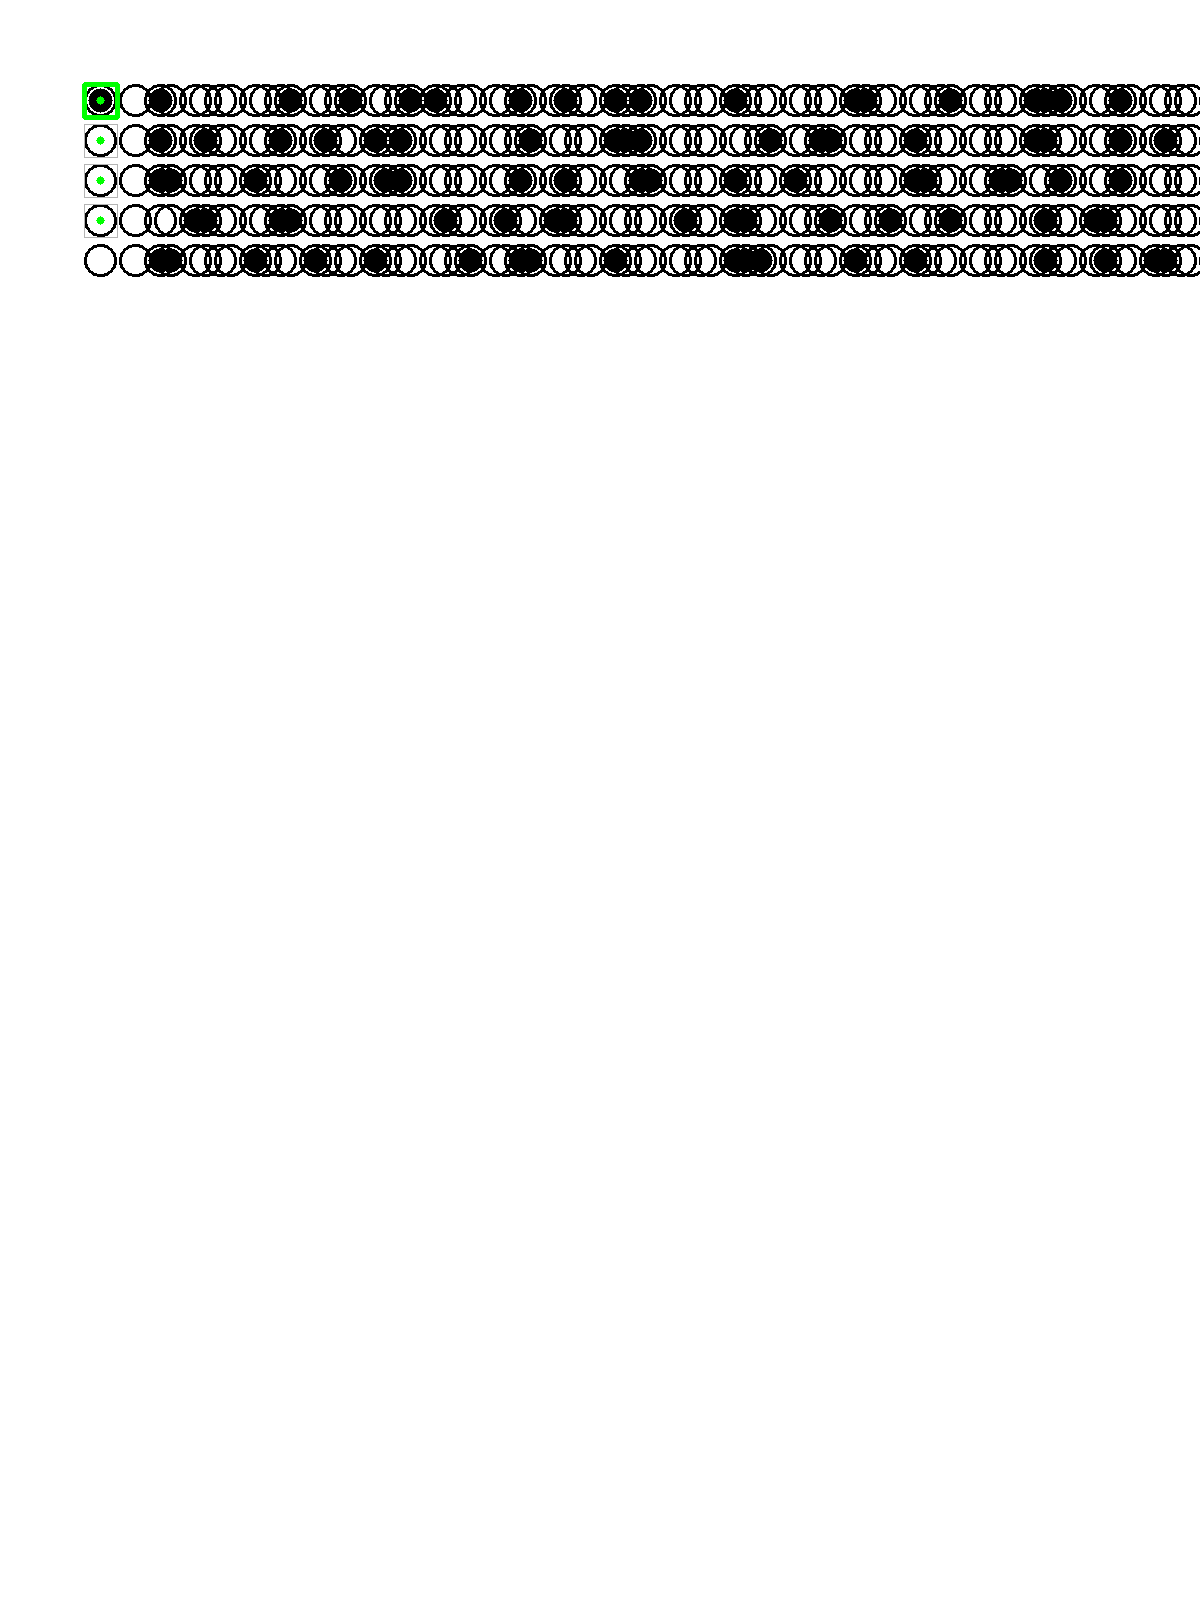

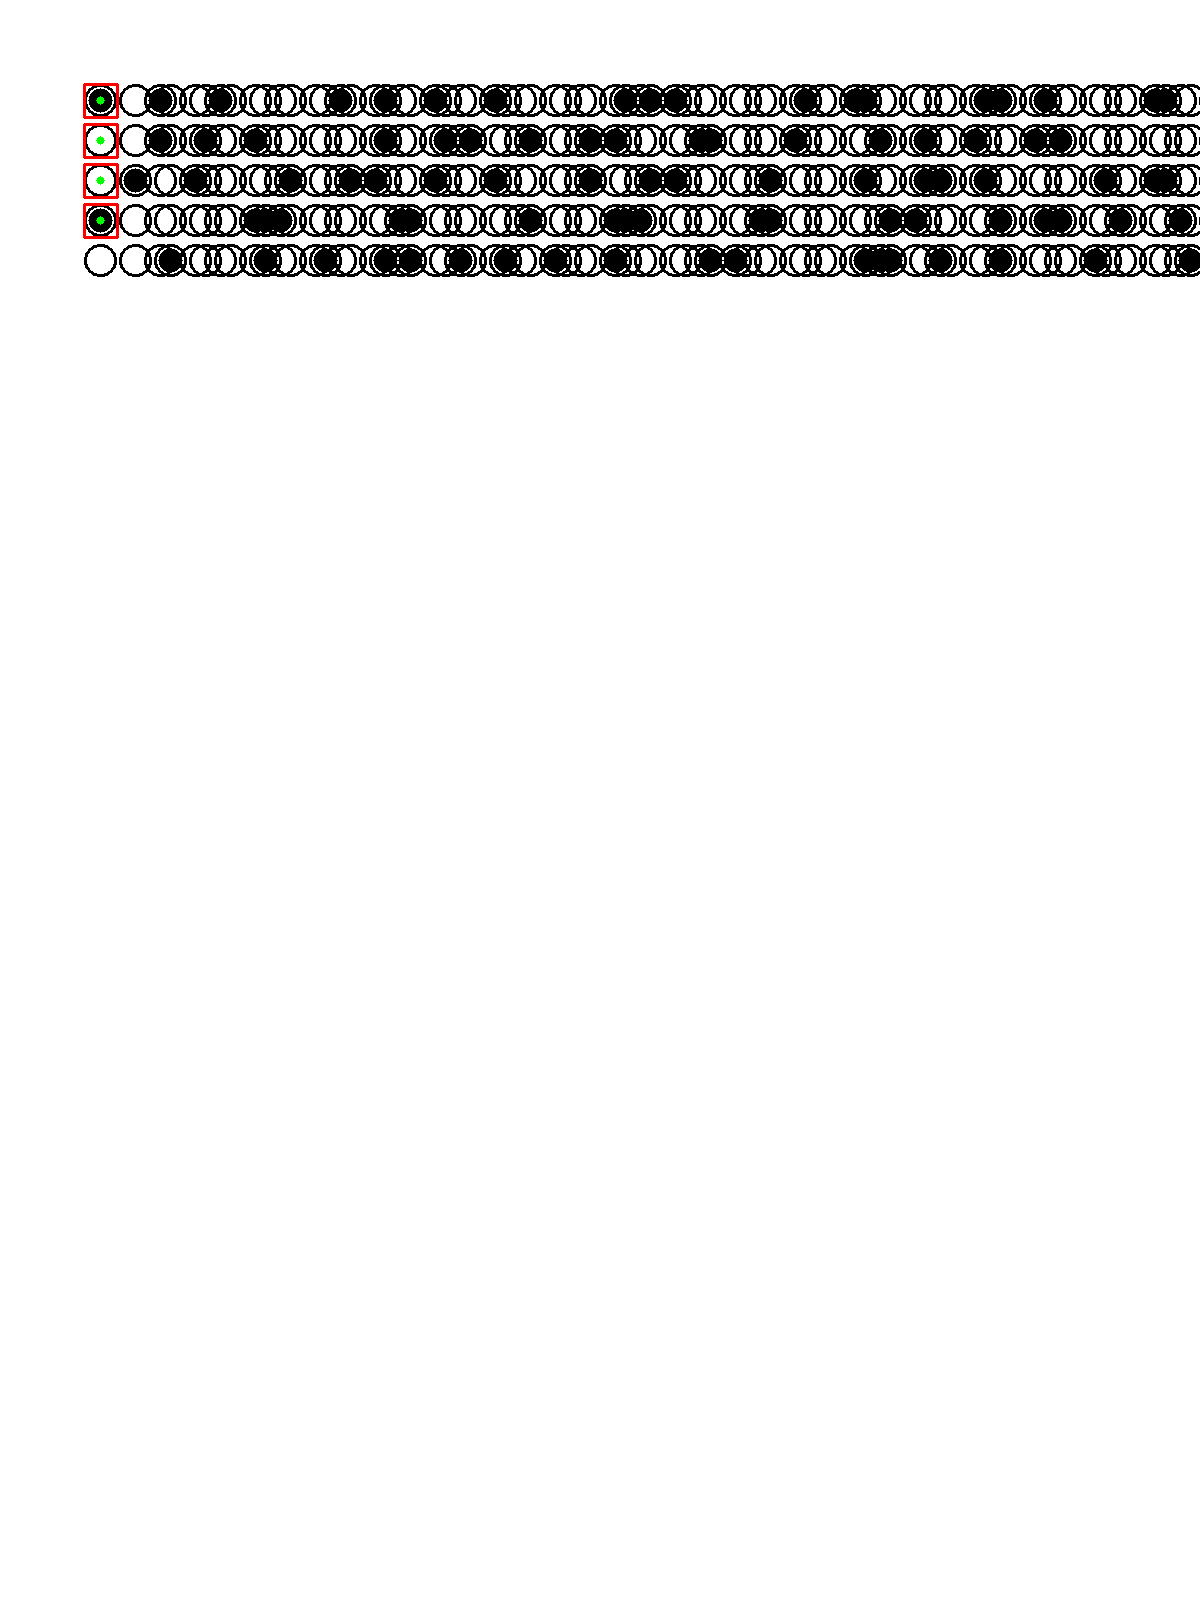

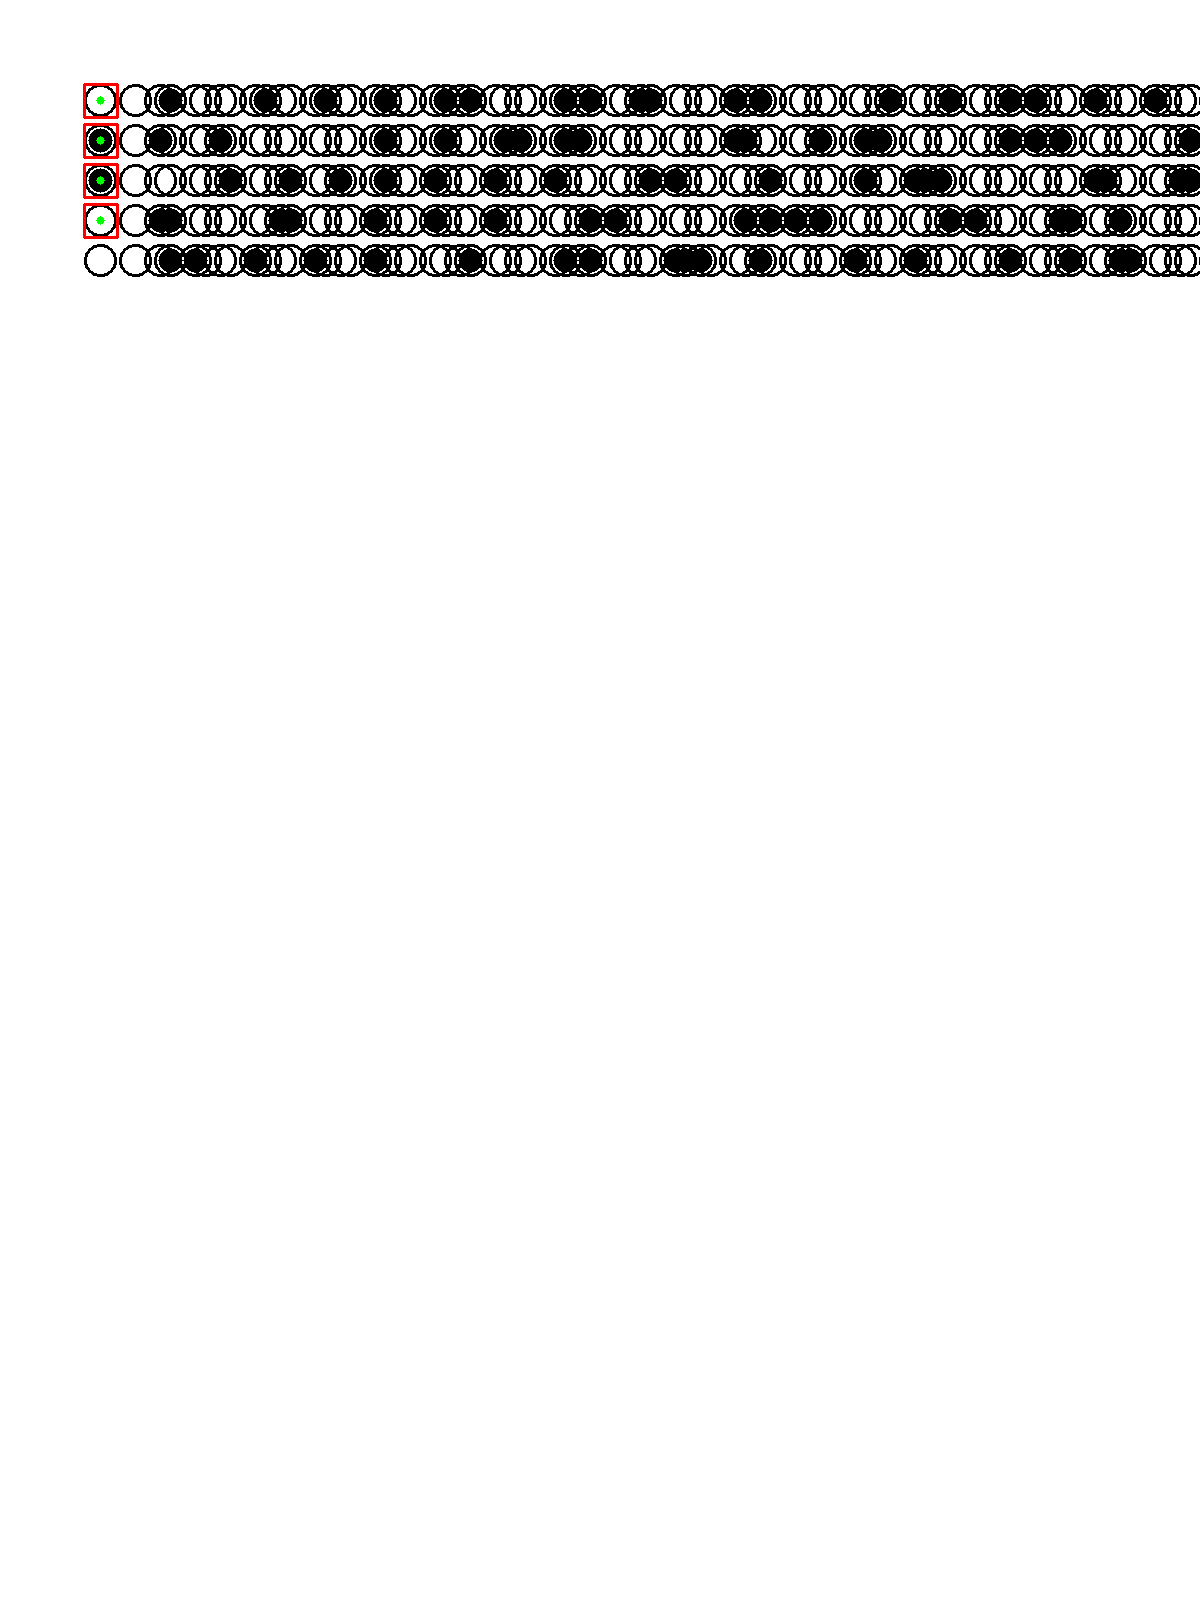

In [27]:
from IPython.display import Image, display

for overlay_img in list(out_dir.glob("*_overlay.png"))[:3]:
    display(Image(filename=str(overlay_img)))


In [ ]:
df_all['correct'] = df_all['correct'].astype(int)
scores = df_all.groupby('sheet')['correct'].sum().reset_index()
scores.rename(columns={'correct':'total_correct'}, inplace=True)
print(scores)
scores.to_csv(out_dir / "sheet_scores.csv", index=False)


     sheet  total_correct
0  sheet_1              0
1  sheet_2              0
2  sheet_3              0
3  sheet_4              0
4  sheet_5              1


In [25]:
# Colab Cell 9 — sample answer keys for two sheet versions (replace with real keys)
# Example: Using 0-based question indices
# Here I create a dummy random key as placeholder. Replace these with actual keys.
import random
random.seed(42)
def random_key(n_q=100, options=['A','B','C','D']):
    return {i: random.choice(options) for i in range(n_q)}

answer_keys = {
    'A': random_key(100),
    'B': random_key(100)  # for different sheet version
}

# Example function to grade answers
def grade_answers(detected_answers, answer_key, per_subject=20):
    # detected_answers is a list of letters ('A'..'D') or '-' or 'M'
    total_questions = len(detected_answers)
    correct_flags = []
    for i in range(total_questions):
        got = detected_answers[i] if i < len(detected_answers) else '-'
        correct = answer_key.get(i, '-')  # expected answer
        correct_flags.append(1 if got == correct else 0)
    # per-subject scores
    subject_scores = []
    for s in range( (total_questions + per_subject - 1)//per_subject ):
        start = s*per_subject
        end = min(start + per_subject, total_questions)
        subject_scores.append(sum(correct_flags[start:end]))
    total_score = sum(subject_scores)
    return {
        'total_score': total_score,
        'subject_scores': subject_scores,
        'correct_flags': correct_flags
    }

# Grade the detected answers (example using version A)
results = grade_answers(detected_answers, answer_keys['A'], per_subject=20)
print("Subject scores:", results['subject_scores'])
print("Total:", results['total_score'], "/100")


Subject scores: [1]
Total: 1 /100


In [ ]:
import streamlit as st
import cv2
import numpy as np
import zipfile
from io import BytesIO

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 83.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 116.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [streamlit]


In [ ]:
uploaded_zip = st.file_uploader("Upload ZIP of OMR sheets", type="zip")
if uploaded_zip:
    with zipfile.ZipFile(BytesIO(uploaded_zip.read())) as z:
        for filename in z.namelist():
            if filename.endswith((".jpg",".png")):
                img_bytes = z.read(filename)
                nparr = np.frombuffer(img_bytes, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                st.image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), caption=filename)


2025-09-20 13:25:56.849 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-20 13:25:56.851 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-20 13:25:56.852 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-20 13:25:56.853 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-20 13:25:56.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-20 13:25:56.858 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [ ]:
# This will create app.py in your Colab environment

app_py = """
import streamlit as st
import cv2
import numpy as np
import zipfile
from io import BytesIO
import os
import json
import pandas as pd
from pathlib import Path

# Define the functions used in the OMR processing
# (assuming these are defined elsewhere in the notebook and can be copied here)
def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]    # top-left
    rect[2] = pts[np.argmax(s)]    # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] # top-right
    rect[3] = pts[np.argmax(diff)] # bottom-left
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts.reshape(4,2))
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def detect_sheet_and_warp(image):
    h,w = image.shape[:2]
    ratio = 800.0 / max(h,w)
    resized = cv2.resize(image, (int(w*ratio), int(h*ratio)))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    docCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        if len(approx) == 4:
            docCnt = approx
            break
    if docCnt is None:
        return image # Return original if no document contour is found
    scale = max(h,w)/800.0
    docCnt_orig = (docCnt.reshape(4,2)*scale).astype(np.float32)
    warped = four_point_transform(image, docCnt_orig)
    return warped

def preprocess_for_bubbles(warped):
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    denoised = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    return denoised

def find_bubble_candidates(thresh_img, min_area=300, max_area=5000):
    cnts, _ = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area or area > max_area: continue
        x,y,w,h = cv2.boundingRect(c)
        ar = w/float(h)
        if ar<0.6 or ar>1.6: continue
        roi = thresh_img[y:y+h, x:x+w]
        filled = cv2.countNonZero(roi)
        filled_ratio = filled / (w*h if w*h>0 else 1)
        cx, cy = x + w//2, y + h//2
        candidates.append({'contour':c,'x':x,'y':y,'w':w,'h':h,'cx':cx,'cy':cy,'filled_ratio':filled_ratio})
    candidates = sorted(candidates, key=lambda d:(d['cy'],d['cx']))
    return candidates

def group_into_rows(candidates, y_tol=15):
    rows=[]
    if not candidates: return rows
    current=[candidates[0]]
    for c in candidates[1:]:
        if abs(c['cy']-current[-1]['cy']) <= y_tol:
            current.append(c)
        else:
            rows.append(sorted(current,key=lambda d:d['cx']))
            current=[c]
    rows.append(sorted(current,key=lambda d:d['cx']))
    return rows


def extract_answers_from_candidates(candidates, options_per_question=4, fill_threshold=0.35):
    rows = group_into_rows(candidates)
    flattened=[]
    for r in rows: flattened.extend(sorted(r,key=lambda d:d['cx']))
    answers=[]
    OPTIONS=['A','B','C','D','E']
    idx=0
    while idx+options_per_question <= len(flattened):
        group = flattened[idx:idx+options_per_question]
        frs = [g['filled_ratio'] for g in group]
        filled_idx = [i for i,fr in enumerate(frs) if fr>=fill_threshold]
        if len(filled_idx)==0:
            answers.append('-')
        elif len(filled_idx)==1:
            answers.append(OPTIONS[filled_idx[0]])
        else:
            answers.append('M') # Mark as multiple
        idx += options_per_question
    return answers

def draw_overlay(warped, candidates, detected_answers, options_per_question=4):
    overlay = warped.copy()
    flattened=[]
    for r in group_into_rows(candidates):
        flattened.extend(sorted(r,key=lambda d:d['cx']))
    idx=0; q_idx=0
    OPTIONS=['A','B','C','D','E']
    while idx+options_per_question <= len(flattened) and q_idx<len(detected_answers):
        group = flattened[idx:idx+options_per_question]
        answer = detected_answers[q_idx]
        for i,g in enumerate(group):
            x,y,w,h = g['x'],g['y'],g['w'],g['h']
            cv2.rectangle(overlay,(x,y),(x+w,y+h),(180,180,180),1)
            if g['filled_ratio']>0.02: cv2.circle(overlay,(g['cx'],g['cy']),max(2,min(w,h)//8),(0,255,0),-1)
        if answer in OPTIONS:
            try:
                chosen=OPTIONS.index(answer)
                if chosen < len(group):
                    g=group[chosen]
                    cv2.rectangle(overlay,(g['x'],g['y']),(g['x']+g['w'],g['y']+g['h']),(0,255,0),3)
            except ValueError:
                 pass # Handle case where answer is not in OPTIONS if necessary
        elif answer=='M':
            for g in group: cv2.rectangle(overlay,(g['x'],g['y']),(g['x']+g['w'],g['y']+g['h']),(0,0,255),2)
        idx+=options_per_question; q_idx+=1
    return overlay


# Assuming answer_keys are defined or loaded elsewhere
# For this Streamlit app, we can define a placeholder or load from a file
answer_keys = {
    'A': {i: chr(ord('A') + i % 4) for i in range(100)}, # Example dummy key
    'B': {i: chr(ord('A') + (i+1) % 4) for i in range(100)} # Example dummy key
}

# Streamlit app code
st.title("OMR Sheet Grader")

uploaded_zip = st.file_uploader("Upload ZIP of OMR sheets", type="zip")
answer_key_version = st.selectbox("Select Answer Key Version", ['A', 'B'])

if uploaded_zip is not None:
    st.write("Processing uploaded ZIP file...")

    out_dir = Path("omr_outputs")
    out_dir.mkdir(exist_ok=True)

    all_results = []
    sheet_summaries = []

    try:
        with zipfile.ZipFile(BytesIO(uploaded_zip.read())) as z:
            image_filenames = [f for f in z.namelist() if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if not image_filenames:
                st.warning("No image files (.png, .jpg, .jpeg) found in the ZIP.")
            else:
                for filename in image_filenames:
                    st.write(f"Processing {filename}...")
                    try:
                        with z.open(filename) as image_file:
                            img_bytes = image_file.read()
                            nparr = np.frombuffer(img_bytes, np.uint8)
                            img_bgr = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                            if img_bgr is None:
                                st.warning(f"Skipping {filename}: Could not read image.")
                                continue

                            warped = detect_sheet_and_warp(img_bgr)
                            thresh = preprocess_for_bubbles(warped)
                            candidates = find_bubble_candidates(thresh)
                            detected_answers = extract_answers_from_candidates(candidates)
                            overlay = draw_overlay(warped, candidates, detected_answers)

                            # Grade
                            results=[]
                            correct_count = 0
                            expected_key = answer_keys.get(answer_key_version, {})
                            for i, det in enumerate(detected_answers):
                                expected = expected_key.get(i,'-')
                                correct = 1 if det==expected else 0
                                results.append({'question':i+1,'detected':det,'expected':expected,'correct':correct})
                                if correct == 1:
                                    correct_count += 1

                            sheet_name = Path(filename).stem
                            sheet_summaries.append({'sheet': sheet_name, 'total_correct': correct_count, 'total_questions': len(detected_answers)})
                            for r in results:
                                r['sheet'] = sheet_name
                                all_results.append(r)

                            # Display overlay image in Streamlit
                            overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
                            st.image(overlay_rgb, caption=f"Processed: {filename}")

                            # Save results (optional in Streamlit, depends on requirements)
                            # You might offer download links instead

                    except Exception as e:
                        st.error(f"Error processing {filename}: {e}")

        if all_results:
            df_all = pd.DataFrame(all_results)
            st.subheader("Detailed Results")
            st.dataframe(df_all)

            st.subheader("Sheet Summary")
            df_summary = pd.DataFrame(sheet_summaries)
            st.dataframe(df_summary)

            # Optional: Provide download links
            csv_output = df_all.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="Download Detailed Results (CSV)",
                data=csv_output,
                file_name='all_sheets_detailed_results.csv',
                mime='text/csv',
            )

            summary_csv_output = df_summary.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="Download Sheet Summary (CSV)",
                data=summary_csv_output,
                file_name='all_sheets_summary.csv',
                mime='text/csv',
            )


    except zipfile.BadZipFile:
        st.error("Invalid ZIP file.")
    except Exception as e:
        st.error(f"An error occurred while processing the ZIP file: {e}")

"""

open('app.py','w').write(app_py)
print("app.py created!")

app.py created!


In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
# Create app.py
app_py = """
import streamlit as st
import cv2, numpy as np, pandas as pd
from io import BytesIO

# ------- Functions for OMR processing -------

def detect_sheet_and_warp(image):
    h, w = image.shape[:2]
    ratio = 800.0 / max(h, w)
    resized = cv2.resize(image, (int(w*ratio), int(h*ratio)))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
    docCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        if len(approx) == 4:
            docCnt = approx
            break
    if docCnt is None:
        return image
    scale = max(h, w)/800.0
    docCnt_orig = (docCnt.reshape(4,2) * scale).astype('float32')
    rect = np.zeros((4,2), dtype="float32")
    s = docCnt_orig.sum(axis=1)
    rect[0] = docCnt_orig[np.argmin(s)]
    rect[2] = docCnt_orig[np.argmax(s)]
    diff = np.diff(docCnt_orig, axis=1)
    rect[1] = docCnt_orig[np.argmin(diff)]
    rect[3] = docCnt_orig[np.argmax(diff)]
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def preprocess_for_bubbles(warped):
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    denoised = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    return denoised

def find_bubble_candidates(thresh_img, min_area=300, max_area=5000):
    cnts, _ = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area or area > max_area:
            continue
        x,y,w,h = cv2.boundingRect(c)
        ar = w / float(h)
        if ar < 0.6 or ar > 1.6:
            continue
        roi = thresh_img[y:y+h, x:x+w]
        total = w*h if w*h>0 else 1
        filled = cv2.countNonZero(roi)
        fr = filled / float(total)
        cx, cy = x + w//2, y + h//2
        candidates.append({'contour': c, 'x':x,'y':y,'w':w,'h':h,'cx':cx,'cy':cy,'area':area,'filled_ratio':fr})
    candidates = sorted(candidates, key=lambda d: (d['cy'], d['cx']))
    return candidates

def group_into_rows(candidates, y_tol=15):
    rows = []
    if not candidates: return rows
    current = [candidates[0]]
    for c in candidates[1:]:
        if abs(c['cy'] - current[-1]['cy']) <= y_tol:
            current.append(c)
        else:
            rows.append(sorted(current, key=lambda d:d['cx']))
            current = [c]
    rows.append(sorted(current, key=lambda d:d['cx']))
    return rows

def extract_answers_from_candidates(candidates, options_per_question=4, fill_threshold=0.35):
    rows = group_into_rows(candidates, y_tol=15)
    flattened = []
    for r in rows: flattened.extend(sorted(r, key=lambda d:d['cx']))
    answers = []
    OPTIONS = ['A','B','C','D','E']
    idx = 0
    while idx + options_per_question <= len(flattened):
        group = flattened[idx:idx+options_per_question]
        frs = [g['filled_ratio'] for g in group]
        filled_idx = [i for i,fr in enumerate(frs) if fr >= fill_threshold]
        if len(filled_idx)==0:
            answers.append('-')
        elif len(filled_idx)==1:
            answers.append(OPTIONS[filled_idx[0]])
        else:
            answers.append('M')
        idx += options_per_question
    return answers

def draw_overlay(warped, candidates, detected_answers, options_per_question=4):
    overlay = warped.copy()
    flattened=[]
    for r in group_into_rows(candidates, y_tol=15):
        flattened.extend(sorted(r, key=lambda d:d['cx']))
    idx=0; q_idx=0
    while idx + options_per_question <= len(flattened) and q_idx < len(detected_answers):
        group = flattened[idx:idx+options_per_question]
        answer = detected_answers[q_idx]
        for i,g in enumerate(group):
            x,y,w,h = g['x'],g['y'],g['w'],g['h']
            cv2.rectangle(overlay, (x,y), (x+w,y+h), (200,200,200), 1)
            if g['filled_ratio'] > 0.02:
                cv2.circle(overlay, (g['cx'], g['cy']), max(2, min(w,h)//8), (0,255,0), -1)
        if answer in ['A','B','C','D','E']:
            chosen = ord(answer) - ord('A')
            g = group[chosen]
            cv2.rectangle(overlay, (g['x'],g['y']), (g['x']+g['w'], g['y']+g['h']), (0,255,0), 3)
        elif answer == 'M':
            for g in group:
                cv2.rectangle(overlay, (g['x'],g['y']), (g['x']+g['w'], g['y']+g['h']), (0,0,255), 2)
        idx += options_per_question; q_idx += 1
    return overlay

# ---------- Streamlit UI ----------
st.title("Automated OMR Evaluation — MVP")
uploaded_file = st.file_uploader("Upload OMR image (jpg/png)", type=['jpg','jpeg','png'])
version = st.selectbox("Answer key version", ['A','B'])
options_per_question = st.number_input("Options per question (A..D => 4)", min_value=2, max_value=5, value=4)

# Demo answer key
def demo_key(n=100, options=['A','B','C','D']):
    import random; random.seed(1)
    return {i: random.choice(options) for i in range(n)}
answer_keys = {'A': demo_key(100), 'B': demo_key(100)}

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    st.image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), caption="Uploaded", use_column_width=True)
    warped = detect_sheet_and_warp(img)
    st.write("Processing image...")
    thresh = preprocess_for_bubbles(warped)
    candidates = find_bubble_candidates(thresh)
    detected = extract_answers_from_candidates(candidates, options_per_question=options_per_question)
    overlay = draw_overlay(warped, candidates, detected, options_per_question=options_per_question)
    st.image(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), caption="Overlay", use_column_width=True)

    # Grade
    grading = [1 if (detected[i] == answer_keys[version].get(i,'-')) else 0 for i in range(min(100, len(detected)))]
    subject_scores = [sum(grading[i*20:(i+1)*20]) for i in range(5)]
    total = sum(subject_scores)
    st.write("Subject scores (each out of 20):", subject_scores)
    st.write("Total score (out of 100):", total)

    # CSV download
    rows=[]
    for i, det in enumerate(detected):
        rows.append({'question': i+1, 'detected': det, 'expected': answer_keys[version].get(i,'-'),
                     'correct': 1 if det == answer_keys[version].get(i,'-') else 0})
    df = pd.DataFrame(rows)
    csv = df.to_csv(index=False).encode('utf-8')
    st.download_button("Download results CSV", data=csv, file_name="omr_results.csv", mime="text/csv")
"""

with open("app.py", "w") as f:
    f.write(app_py)

print("app.py created successfully!")


app.py created successfully!


In [ ]:
requirements = """
streamlit
opencv-python-headless
numpy
pandas
Pillow
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

print("requirements.txt created!")


requirements.txt created!


In [ ]:
!ls -l


total 188
-rw-r--r-- 1 root root   7322 Sep 20 13:23 app.py
drwxr-xr-x 2 root root   4096 Sep 20 11:05 omr_images
drwxr-xr-x 2 root root   4096 Sep 20 11:24 omr_outputs
-rw-r--r-- 1 root root     54 Sep 20 13:20 requirements.txt
drwxr-xr-x 1 root root   4096 Sep 16 13:40 sample_data
-rw-r--r-- 1 root root 167232 Sep 20 11:05 sample_omr_sheets.zip


In [ ]:
!git clone https://huggingface.co/spaces/spark-hack/OMR_Evalution_Scroning
!cp /content/app.py /content/requirements.txt OMR_Evalution_Scroning/
%cd OMR_Evalution_Scroning
!git add .
!git commit -m "Add OMR Streamlit app"
!git push


Cloning into 'OMR_Evalution_Scroning'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 8 (from 2)
Unpacking objects: 100% (11/11), 3.80 KiB | 973.00 KiB/s, done.
/content/OMR_Evalution_Scroning
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@dcdb317de7ee.(none)')
fatal: could not read Username for 'https://huggingface.co': No such device or address


In [ ]:
!git config --global user.email "muthyapuharshitha05@gmail.com"
!git config --global user.name "spark-hack"


In [ ]:
HF_TOKEN = "OMr"
!git remote set-url origin https://huggingface.co/spark-hack/OMR_Evalution_Scroning


In [ ]:
%cd /content/OMR_Evalution_Scroning


/content/OMR_Evalution_Scroning


In [ ]:
!git add .
!git commit -m "Add OMR Streamlit app"


On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [ ]:
%cd /content/OMR_Evalution_Scroning


!git add .
!git commit -m "Add OMR Streamlit app"

!git push https://OMr@huggingface.co/spark-hack/OMR_Evalution_Scroning.git main



/content/OMR_Evalution_Scroning
On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
fatal: could not read Password for 'https://OMr@huggingface.co': No such device or address


In [ ]:
!git remote remove origin
!git remote add origin https://huggingface.co/spaces/spark-hack/OMR_Evalution_Scroning/tree/main


In [ ]:
!git push -u origin main


fatal: repository 'https://huggingface.co/spaces/spark-hack/OMR_Evalution_Scroning/tree/main/' not found


In [ ]:

!git config --global user.email "muthyapuharshitha05@gmail.com"
!git config --global user.name "spark-hack"


%cd /content/OMR_Evalution_Scroning

!git remote remove origin

HF_TOKEN = "OMr"
!git remote add origin https://OMr@huggingface.co/spark-hack/OMR_Evalution_Scroning.git


!git add .
!git commit -m "Add OMR Streamlit app" || echo "Nothing to commit"


!git push -u origin main


/content/OMR_Evalution_Scroning
On branch main
nothing to commit, working tree clean
Nothing to commit
fatal: could not read Password for 'https://OMr@huggingface.co': No such device or address


In [ ]:

!git add .
!git commit -m "Add OMR Streamlit app"
!git push origin main


On branch main
nothing to commit, working tree clean
fatal: could not read Password for 'https://OMr@huggingface.co': No such device or address
